In [1]:
import torch
import sys
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

data_augmentation = True
batch_size_var = 1024
batch_norm_var = True

num_epochs = 100
early_stop_thresh = 3


## Data augmentation 

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

# Original transformation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size_var, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size_var, shuffle=False)

# Data augmentation transformation
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a new dataset with augmented images
augmented_dataset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=augmentation_transform)

# Concatenate the original trainset with the augmented dataset
combined_trainset = ConcatDataset([trainset, augmented_dataset])

# Create DataLoader for the combined training set only if we want it
if (data_augmentation):
    train_loader = DataLoader(combined_trainset, batch_size=batch_size_var, shuffle=True)
    print("Yes data augmentation")
else:
    print("No dat augmentation")


Files already downloaded and verified
Files already downloaded and verified
Yes data augmentation


In [3]:
for images, labels in train_loader:
  print(images.size(), labels.size())
  break
    
    
# Compare sizes of the original trainset and the augmented combined trainset
original_trainset_size = len(trainset)
augmented_trainset_size = len(augmented_dataset)
combined_trainset_size = len(combined_trainset)

print(f"Original Trainset Size: {original_trainset_size}")
print(f"Augmented Trainset Size: {augmented_trainset_size}")
print(f"Combined Trainset Size: {combined_trainset_size}")

torch.Size([1024, 3, 32, 32]) torch.Size([1024])
Original Trainset Size: 50000
Augmented Trainset Size: 50000
Combined Trainset Size: 100000


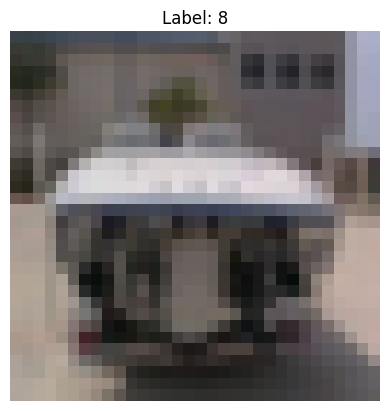

In [4]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

## Model design

In [5]:
class CustomCNNCifar(nn.Module):
    def __init__(self, num_classes=10, batch_norm = True):
        super(CustomCNNCifar, self).__init__()
        self.batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        #16x16x 8
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        #8x8x16
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        #4x4x32
        if self.batch_norm:
            self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        #2x2x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        #1x1x64
        if self.batch_norm:
            self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()

        self.flatten = nn.Flatten()        
                
        self.fc1 = nn.Linear(64, num_classes)
       
        self.log_softmax = nn.LogSoftmax(dim=1)  # Softmax activation for classification



    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.pool1(x)
        x = self.relu4(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        
        x = self.log_softmax(x)  # Apply softmax for classification
        return x

# Create an instance of the SimpleCNNReduced model
model = CustomCNNCifar(num_classes=10, batch_norm = batch_norm_var)
if(batch_norm_var):
    print("Using batch norm")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate the total number of trainable parameters
total_params_reduced = count_parameters(model)
print(f"Total trainable parameters in the reduced model: {total_params_reduced}")

Using batch norm
Total trainable parameters in the reduced model: 25418


In [6]:
print(model.to(device))

CustomCNNCifar(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_featu

## Use early stopping to prevent overfitting

In [7]:
model = CustomCNNCifar(num_classes=10, batch_norm = batch_norm_var)

model = model.to(device)
optimizer = Adam(model.parameters())
criterion = nn.NLLLoss()

cum_epoch_loss = 0

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

best_val = sys.maxsize

start_time = time.time()

best_val_e = sys.maxsize
best_epoch = 0

# Training loop for each fold
for e in range(num_epochs):
    batch_loss = 0

    # Training phase
    model.train()
    for batch, (inputs, outputs) in enumerate(train_loader, 1):
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        #print(f'Epoch({e + 1}/{num_epochs}: Batch number({batch}/{len(train_fold_loader)}) : Batch loss : {loss.item()}')
    print(f'Epoch({e + 1}/{num_epochs})')
    print(f'Training loss : {batch_loss / len(train_loader)}')
    #change device to cpu?

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_val, (inputs, outputs) in enumerate(test_loader, 1):
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, outputs)

            val_loss += loss.item()

        print(f'Validation loss : {val_loss / len(test_loader)}')

        val_epoch = val_loss / len(test_loader)

        #Best model checkpointing
        if(val_epoch < best_val):
            print(f'Checkpointing new best model in epoch {e+1}')
            checkpoint(model, f"best_model.pkl")
            best_val = val_epoch

    #Check val loss of epoch for early stopping
    if val_epoch < best_val_e:
        best_val_e = val_epoch
        best_epoch = e

    #Early stopping
    if e - best_epoch > early_stop_thresh:
        print(f'Early stopped training at epoch {e+1}')
        break  # terminate the training loop
               
print(f'\nFinal, best val error: {best_val}')

end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed Time: {minutes} minutes and {seconds} seconds")


Epoch(1/100)
Training loss : 1.839875457238178
Validation loss : 1.5561207294464112
Checkpointing new best model in epoch 1
Epoch(2/100)
Training loss : 1.5625510094117145
Validation loss : 1.355291473865509
Checkpointing new best model in epoch 2
Epoch(3/100)
Training loss : 1.466362106556795
Validation loss : 1.2863093614578247
Checkpointing new best model in epoch 3
Epoch(4/100)
Training loss : 1.4042760121579072
Validation loss : 1.2252084136009216
Checkpointing new best model in epoch 4
Epoch(5/100)
Training loss : 1.3595500539760201
Validation loss : 1.197614812850952
Checkpointing new best model in epoch 5
Epoch(6/100)
Training loss : 1.3189682790211268
Validation loss : 1.1704347133636475
Checkpointing new best model in epoch 6
Epoch(7/100)
Training loss : 1.2863960266113281
Validation loss : 1.136547613143921
Checkpointing new best model in epoch 7
Epoch(8/100)
Training loss : 1.2591474956395674
Validation loss : 1.1367436289787292
Epoch(9/100)
Training loss : 1.23206847176259

In [8]:
model.to('cpu')

model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for batch, (images, labels) in enumerate(test_loader,1):

        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(test_loader)})')

        # if batch == 5:
         # break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/10)
Batch (2/10)
Batch (3/10)
Batch (4/10)
Batch (5/10)
Batch (6/10)
Batch (7/10)
Batch (8/10)
Batch (9/10)
Batch (10/10)
Accuracy of the model on 10000 test images: 67.11% 
